In [3]:
from transforms import *

In [8]:
data = np.load("nyx_red.npy")
data = data.astype((np.float64))

data = ndimage.gaussian_filter1d(data, sigma=2, axis=1)

data = data.reshape(2500, -1, 32).mean(axis=2)

data = data.flatten() + 1e-300
data2 = data.flatten() + 1e-300

data_std = data.std()
data_mean = data.mean()

end_point = 200000
start_point = 0

data = data[start_point:end_point]

batch_size = end_point - start_point


In [9]:
tf.reset_default_graph()

In [10]:
F = tf.placeholder(tf.float64, shape=[None])
#many of the outputs here are for debugging purposes (for example each transform also outputs the input variables)

recursion = 2
#reverse fgpa

FGPA_params = FGPA_Layer('1_', .3, 1.6, 1.5, constant=True)

nfgpa, A, alpha, sigma = NFGPA(F, FGPA_params)

nfgpa_std = tf.math.reduce_std(nfgpa)
nfgpa_mean = tf.math.reduce_mean(nfgpa)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    nfgpa_std_temp, nfgpa_mean_temp = sess.run([nfgpa_std, nfgpa_mean], {F:data})

    nfgpa_std = nfgpa_std_temp
    nfgpa_mean = nfgpa_mean_temp

#use this to transform the data after opt
YJ_params = YJ_Layer(layer='1_', eta_input=.1+1e-50, eps_input=.1+1e-50, beta_input=nfgpa_std, mean_input=nfgpa_mean, eta_constraint=[-3, 3-1e-50], eps_constraint=[-1+1e-50, 1-1e-50], beta_constraint=[-5, 5], vary_mean=True, vary_beta=False)
YJ_params2 = YJ_Layer(layer='2_', eta_input=.1+1e-50, eps_input=+.1+1e-50, beta_input=nfgpa_std, mean_input=0.0, eta_constraint=[-3, 3-1e-50], eps_constraint=[-1+1e-50, 1-1e-50], beta_constraint=[-5, 5], vary_mean=False, vary_beta=False)
#YJ_params3 = YJ_Layer(layer='3_', eta_input=1e-50, eps_input=1e-50, beta_input=nfgpa_std, mean_input=0.0, eta_constraint=[-2, 2-1e-50], eps_constraint=[-1+1e-50, 1-1e-50], beta_constraint=[-5, 5], vary_mean=False, vary_beta=True)
#YJ_params4 = YJ_Layer(layer='4_', eta_input=1e-50, eps_input=-1e-50, beta_input=data_std, mean_input=0.0, eta_constraint=[-5., 5.], eps_constraint=[-1.+1e-50, -1e-50], vary_mean=False)

r, eta, eps, beta, mean = YJ(nfgpa, YJ_params, recursion_num=recursion)
r2, eta2, eps2, beta2, mean2 = YJ(r, YJ_params2, recursion_num=recursion)
#r3, eta3, eps3, beta3, mean3 = YJ(r2, YJ_params3, recursion_num=recursion)
#r4, eta4, eps4, beta4, mean4 = YJ(r3, YJ_params4, recursion_num=recursion)

#r_inv = JY(r, YJ_params)
#fgpa = FGPA(r_inv, FGPA_params)

#likelihood
likilihood_params = log_likilihood_Layer('1_', input_hess=nfgpa_std, vary_hess=True)
loss, outline, hess, r_g = log_likilihood(F, r2, likilihood_params)


rand = tf.placeholder(tf.float64, shape=[None])

rand_JY = JY(rand, YJ_params, recursion_num=recursion)
rand2_JY = JY(rand_JY, YJ_params2, recursion_num=recursion)
#rand3_JY = JY(rand2_JY, YJ_params3, recursion_num=recursion)
#rand4_JY = JY(rand3_JY, YJ_params4, recursion_num=recursion)

fgpa = FGPA(rand2_JY, FGPA_params)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    value = sess.run([F, loss], {F:data})
    print(value)
    

[array([0.86365435, 0.9472686 , 0.98018721, ..., 0.9881573 , 0.99012188,
       0.984669  ]), -215350.1080066185]


In [12]:
#tensorflow optmization./display parameters
learn_rate = tf.placeholder(tf.float64)

training_epochs = 2000
display_step = 100

optimizer = tf.train.AdamOptimizer(learning_rate = learn_rate,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-08)
gradients, variables = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, .01)
opt = optimizer.apply_gradients(zip(gradients, variables))

In [13]:
import time

t0 = time.time()

init = tf.global_variables_initializer()


random_sims = 2
fitted_params = []
transformed_data = []
pdf_og = []
recreated_pdf = []
loss_over_iterations = []
params_over_iterations = []

with tf.Session() as sess:
    # Run the initializer
    sess.run(init)
    # Fit all training data
    F_temp, loss_temp = sess.run([F, loss], {F:data})
    print("Epoch:0 cost= " + str(loss_temp))
    d = sess.run([A, alpha, sigma, eta, eps, hess, mean], {F: data})
    print("parameters=", str(d))

    for epoch in range(training_epochs):

        datum = np.random.choice(data, 20000)
        learn_rate_formula = .1*np.exp(-.00205388*epoch)
        opt.run(feed_dict={F:datum, learn_rate:learn_rate_formula})
        # Display logs per epoch step
        # Display parameters changing per epoch step
        c = sess.run(loss, feed_dict={F: datum})
        loss_over_iterations.append(c)
        d = sess.run([A, alpha, sigma, eta, eps,  eta2, eps2, hess, mean], {F: datum})
        params_over_iterations.append(d)

        if (epoch+1) % display_step == 0:

            c = sess.run(loss, feed_dict={F: datum})
            print("Epoch:" + str(epoch+1), "cost=", str(c))
            d = sess.run([A, alpha, sigma, eta, eps,  eta2, eps2, hess, mean], {F: datum})
            print("parameters=", str(d))
            print("current learning rate=", str(learn_rate_formula))


    print("Optimization Finished!")

    transformed_data = sess.run([r2], {F:data})
    final_loss = sess.run([loss], {F:data})
    print(final_loss)
    lin = np.linspace(1e-4, 1-1e-3, 10000)
    pdf_og = sess.run([outline], {F: lin})
    (mu, sig) = stats.norm.fit(transformed_data)
    x = sig*random.randn(10000000) + mu
    recreated_pdf = sess.run([fgpa], {rand: x})
    #[array([0.3]), array([1.6]), array([1.5]), -0.8467859146558865, 0.28081627592304287, 1.1849458417094794, -0.26679847135928836, 0.6791027359690649, 0.2168417741209921]
t1 = time.time()
total = t1-t0
print(total)

Epoch:0 cost= -215350.1080066185
parameters= [array([0.3]), array([1.6]), array([1.5]), 0.1, 0.1, 0.9820359704433217, 0.301893611758974]
Epoch:100 cost= -27661.760744851257
parameters= [array([0.3]), array([1.6]), array([1.5]), 0.9925667180459145, -0.14600389205006015, -0.6129983210421813, -0.1197733171603754, 0.8880824191894532, 0.19764644734040776]
current learning rate= 0.08160055520976008
Epoch:200 cost= -24780.93279779359
parameters= [array([0.3]), array([1.6]), array([1.5]), 1.1327073035625845, -0.03967371652218732, -0.6492572173547925, -0.23463812546051543, 0.7746006004340151, 0.2147028253690515]
current learning rate= 0.06644988576117443
Epoch:300 cost= -25816.26741841993
parameters= [array([0.3]), array([1.6]), array([1.5]), 1.1832895039045008, -0.010652951014255589, -0.7119326964203836, -0.28776223215933516, 0.7554831341166813, 0.1721611310921884]
current learning rate= 0.05411222149558355
Epoch:400 cost= -25989.753847216845
parameters= [array([0.3]), array([1.6]), array([1.5

/usr/common/software/tensorflow/intel-tensorflow/1.15.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


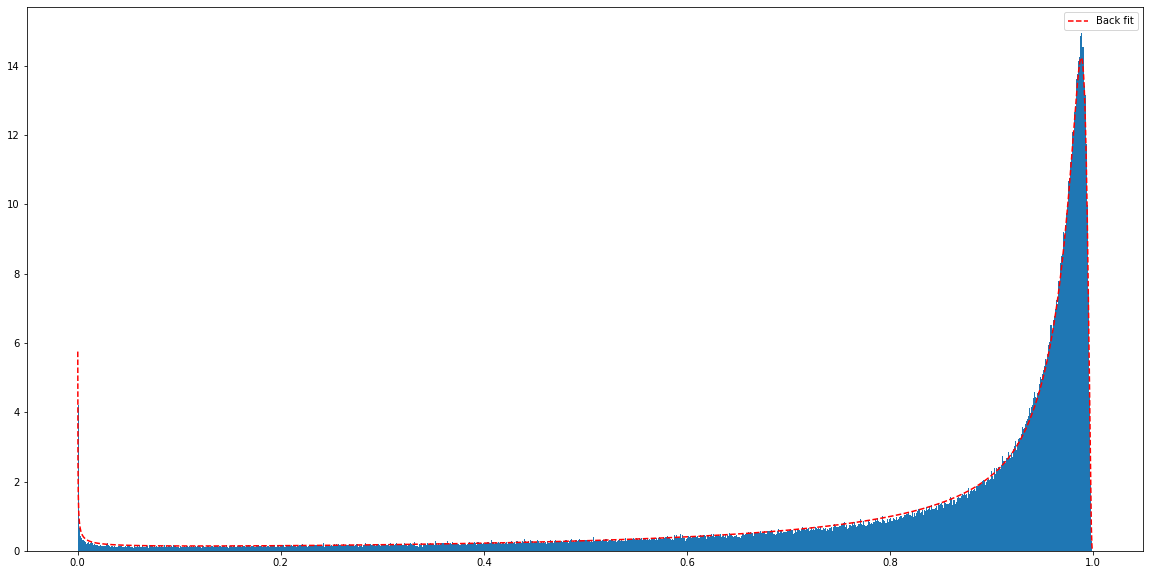

/usr/common/software/tensorflow/intel-tensorflow/1.15.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


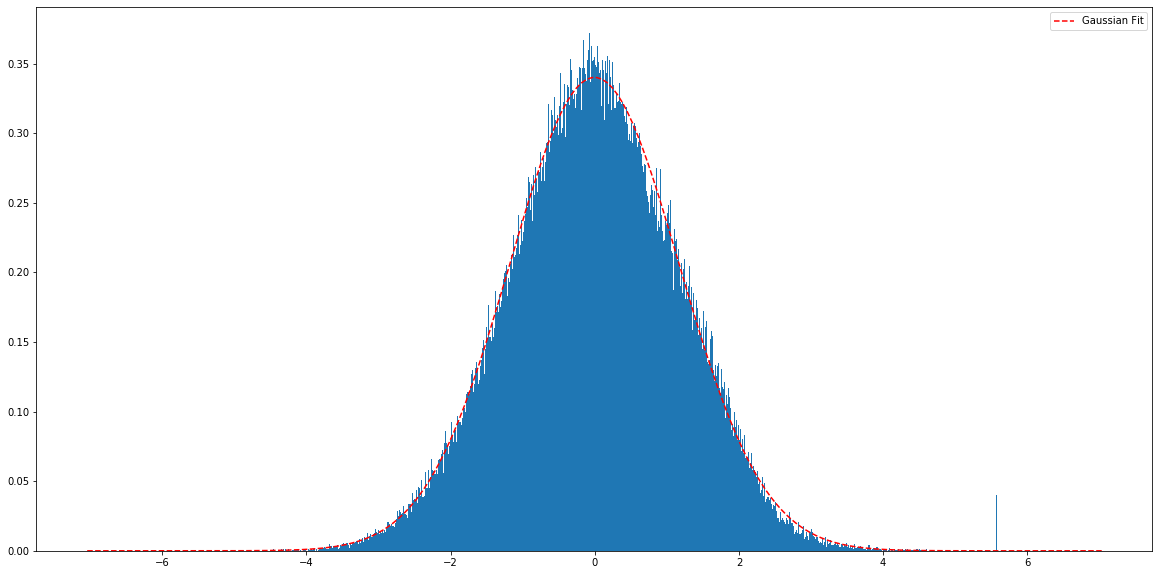

/usr/common/software/tensorflow/intel-tensorflow/1.15.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:19: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


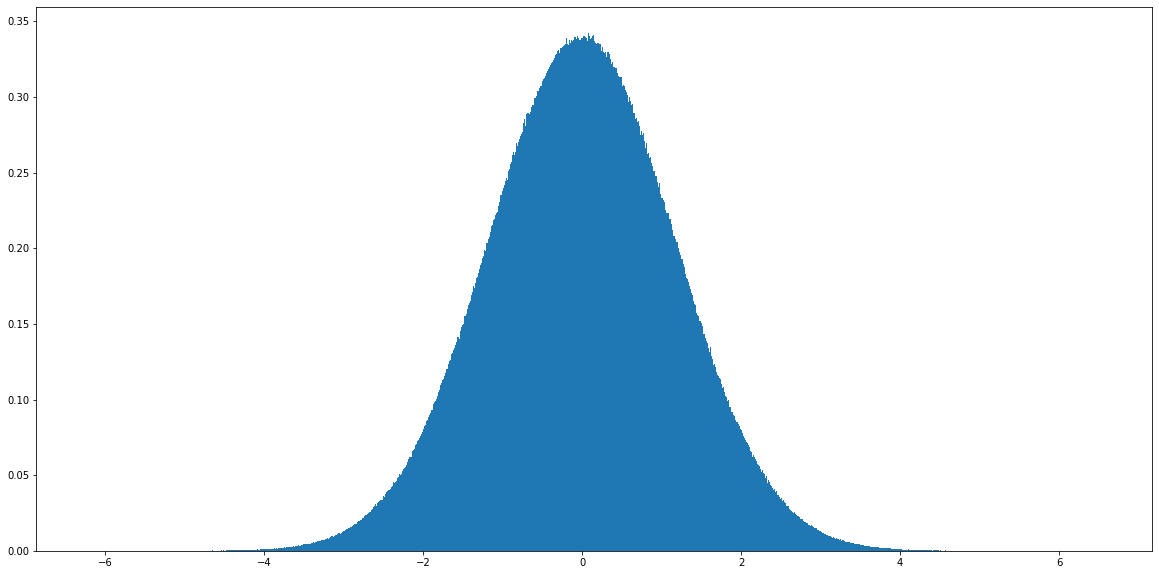

/usr/common/software/tensorflow/intel-tensorflow/1.15.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:24: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


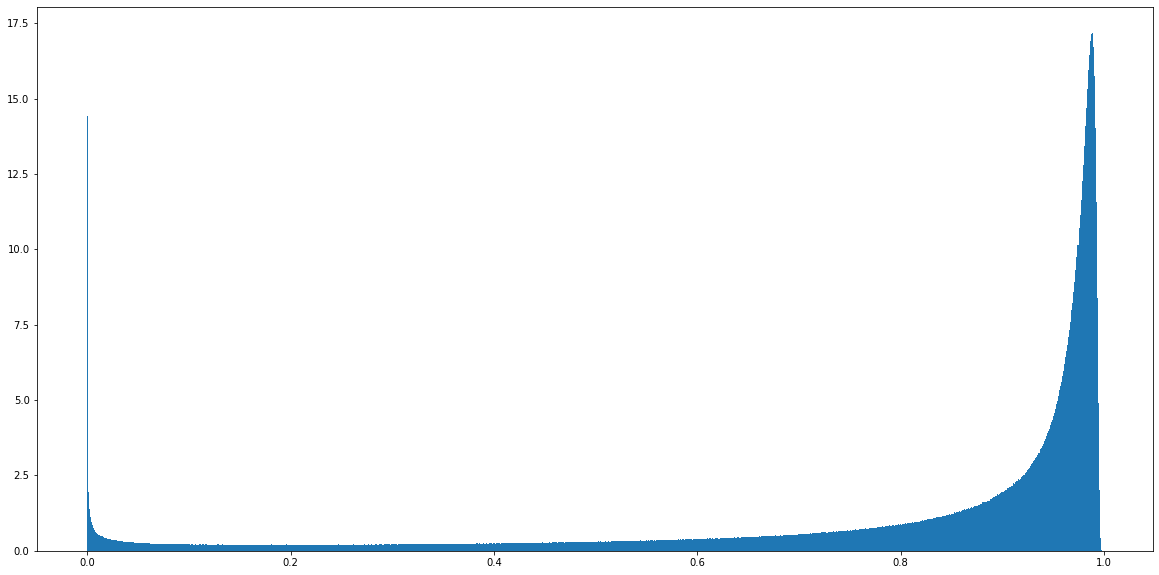

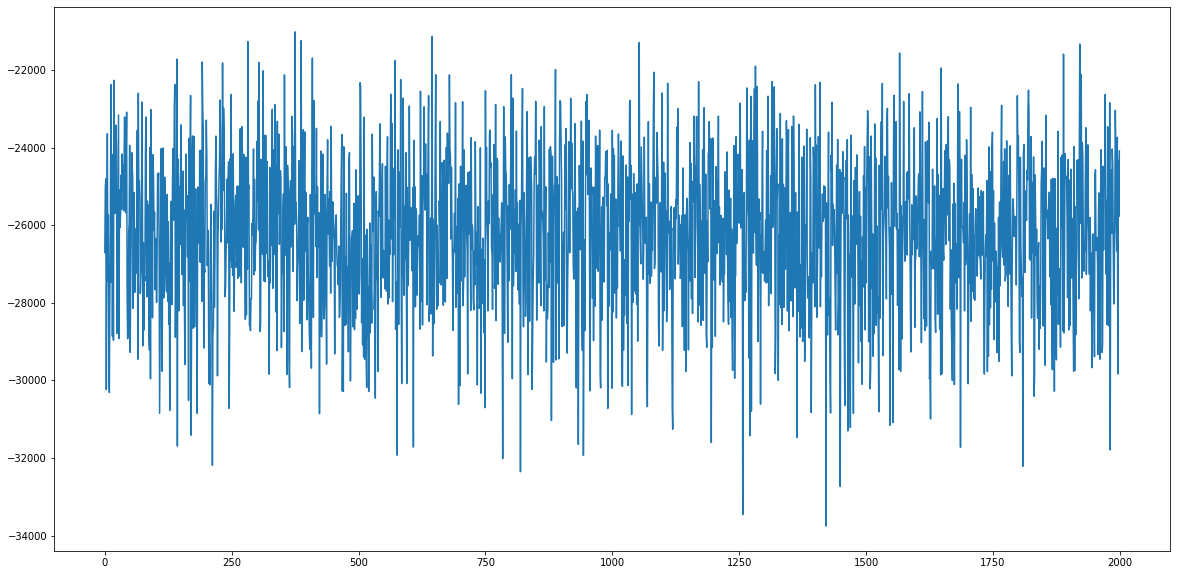

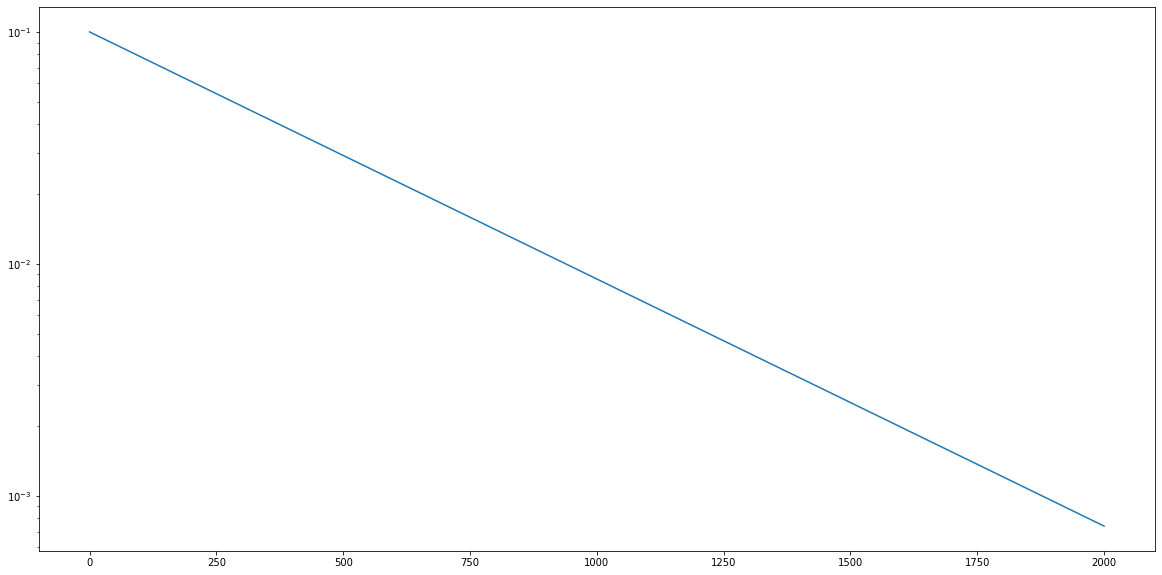

In [14]:
with tf.Session() as sess:
    plt.figure(figsize=(20,10))
    plt.plot(lin, np.array(pdf_og).flatten(), color='r', label="Back fit", ls='--')
    n2, bins2, patches2 = plt.hist(data2, bins=1000, normed=True)
    plt.legend()
    plt.show()
    
    (mu, sig) = stats.norm.fit(transformed_data)
    x = np.linspace(mu-6*sig,mu+6*sig,200)
    pdf = stats.norm.pdf(x, loc=mu, scale=sig)
    plt.figure(figsize=(20,10))
    plt.plot(x, pdf, color='r', label="Gaussian Fit", ls='--')
    n, bins, patches = plt.hist(transformed_data, bins=1000, normed=True)
    plt.legend()
    plt.show()
    
    x = sig*random.randn(10000000) + mu
    plt.figure(figsize=(20,10))
    n, bins, patches = plt.hist(x, bins=1000, normed=True)
    plt.show()
    
    
    plt.figure(figsize=(20,10))
    n, bins, patches  =plt.hist(recreated_pdf, bins=1000, normed=True)
    plt.show()
 
    plt.figure(figsize=(20,10))
    plt.plot(loss_over_iterations)
    plt.show()
    plt.figure(figsize=(20,10))
    epoch_space = np.linspace(0,2000)
    plt.yscale('log')
    plt.plot(epoch_space, .1*np.exp(-.00245388*epoch_space))